# 卷积层
每一次卷积运算是将卷积核元素与图片各个通道按元素相乘再相加
# 池化层
## 局部池化
池化层的通道数与输入的通道数相同，是对每个通道进行最大或平均池化操作
## 全局池化
全局池化可以替代卷积神经网络顶层的全连接层
***
![title](./img/cnn.png)


In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets


In [62]:
transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5])])
train_data = datasets.CIFAR10(root='./cifar10', download=True, transform=transform, train=True)
test_data = datasets.CIFAR10(root='./cifar10', train=False, download=True, transform=transform)

trainloader = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=2)
testloader = DataLoader(test_data, batch_size=64, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


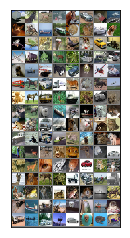

In [63]:
classes = ['plane', 'car',
           'bird', 'cat', 
          'deer', 'dog', 
          'frog', 'horse', 
          'ship', 'truck']
# 查看部分数据
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def show_img(img):
    img = img / 2 + 0.5
    img = img.numpy()
    plt.imshow(np.transpose(img, [1,2,0]))
    plt.xticks([])
    plt.yticks([])
    plt.show()

img_iter = enumerate(trainloader)
img_idx, (imgs, labels) = next(img_iter)

show_img(torchvision.utils.make_grid(imgs))

# 普通卷积网络

In [73]:
class CNNNet(nn.Module):
    def __init__(self):
        super(CNNNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=36, kernel_size=3, stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(1296, 128)
        self.fc2 = nn.Linear(128, 10)
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = x.view(-1, 36 * 6 * 6)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return x

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
net = CNNNet().to(device)

# 参数初始化
# for m in net.children():
#     if isinstance(m, nn.Conv2d):
#         nn.init.kaiming_uniform_(m.weight)
#         nn.init.constant_(m.bias, 0)
#     elif isinstance(m, nn.Linear):
#         nn.init.normal_(m.weight)
#         nn.init.constant_(m.bias, 0)

In [74]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [75]:
# 模型训练
from torch.utils.tensorboard import SummaryWriter

sw = SummaryWriter(log_dir='./logs', comment='cifar')
for epoch in range(20):
    net.train() # !!!!
    train_loss = 0
    for i, data in enumerate(trainloader):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        # 正向传播
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step() 
        train_loss += loss.item()
    train_loss = train_loss / len(trainloader)
    print('epoch{} train_loss:{}'.format(epoch, loss.item()))
    sw.add_scalar('train_loss', train_loss, epoch)
    

epoch0 train_loss:2.2888944149017334
epoch1 train_loss:2.2503647804260254
epoch2 train_loss:2.156006336212158
epoch3 train_loss:1.944329857826233
epoch4 train_loss:1.9021316766738892
epoch5 train_loss:1.683129072189331
epoch6 train_loss:1.7799160480499268
epoch7 train_loss:1.5232748985290527
epoch8 train_loss:1.7698099613189697
epoch9 train_loss:1.5133230686187744
epoch10 train_loss:1.602964997291565
epoch11 train_loss:1.3902052640914917
epoch12 train_loss:1.440149188041687
epoch13 train_loss:1.5711359977722168
epoch14 train_loss:1.3372689485549927
epoch15 train_loss:1.344274640083313
epoch16 train_loss:1.3669514656066895
epoch17 train_loss:1.5618890523910522
epoch18 train_loss:1.3423197269439697
epoch19 train_loss:1.3684122562408447


In [ ]:
# 